In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer

local_model_path = "/home/user31/polina/Llama-3.2-3B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    local_model_path,
    device_map="cuda:0",
    # load_in_4bit=True,            # активируем 4-bit квантование
    torch_dtype="auto"            # автоматически выбираем тип данных
)

tokenizer = AutoTokenizer.from_pretrained(local_model_path)

/home/user31/.conda/envs/tinyllama-env/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
import warnings
import transformers
import os 
# 1. Подавление всех Python-предупреждений
warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"
transformers.logging.set_verbosity_error()

In [3]:
import torch
from tqdm import tqdm
torch.cuda.is_available()
from copy import deepcopy

DEVICE = model.device
DEVICE

device(type='cuda', index=0)

In [4]:
# from torchinfo import summary

# summary(model, input_size=(1, 64), dtypes=[torch.long])
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((3072,), eps=1e

In [5]:
from datasets import load_dataset
from transformers import pipeline
import evaluate

metric = evaluate.load("accuracy")


In [6]:
all_subtasks = ['abstract_algebra', 'all', 'anatomy', 'astronomy', 'auxiliary_train', 'business_ethics', 'clinical_knowledge', 'college_biology', 'college_chemistry', 'college_computer_science', 'college_mathematics', 'college_medicine', 'college_physics', 'computer_security', 'conceptual_physics', 'econometrics', 'electrical_engineering', 'elementary_mathematics', 'formal_logic', 'global_facts', 'high_school_biology', 'high_school_chemistry', 'high_school_computer_science', 'high_school_european_history', 'high_school_geography', 'high_school_government_and_politics', 'high_school_macroeconomics', 'high_school_mathematics', 'high_school_microeconomics', 'high_school_physics', 'high_school_psychology', 'high_school_statistics', 'high_school_us_history', 'high_school_world_history', 'human_aging', 'human_sexuality', 'international_law', 'jurisprudence', 'logical_fallacies', 'machine_learning', 'management', 'marketing', 'medical_genetics', 'miscellaneous', 'moral_disputes', 'moral_scenarios', 'nutrition', 'philosophy', 'prehistory', 'professional_accounting', 'professional_law', 'professional_medicine', 'professional_psychology', 'public_relations', 'security_studies', 'sociology', 'us_foreign_policy', 'virology', 'world_religions']
len(all_subtasks)

59

In [7]:
## Format prompt with one-shot example
def format_mmlu_prompt(example, preprompt = None ):

    prompt = f"Question: {example['question']}\n"
    prompt += "Choices:\n"
    for i, choice in enumerate(example['choices']):
        prompt += f"{chr(ord('A') + i)}. {choice}\n"
    prompt += "Give your answer. Just give the choice.\n"
    
    return preprompt + prompt

# def format_mmlu_prompt(ex, num_shots=5, shots= None):
#     # Примеры для few-shot
    
    
#     prompt = ""
#     for shot in shots:
#         prompt += f"Q: {shot['question']}\n"
#         for i, choice in enumerate(shot['choices']):
#             prompt += f"{i+1}. {choice}\n"
#         prompt += f"A: {shot['choices'][shot['answer']]}\n\n"

#     # Текущий вопрос
#     prompt += f"Q: {ex['question']}\n"
#     for i, choice in enumerate(ex['choices']):
#         prompt += f"{i+1}. {choice}\n"
#     prompt += f"A:"
    
#     return prompt


In [8]:
def extract_answer(output, choices):
    answer_part = output.split("A:")[-1].strip().lower()
    
    # Проверяем буквы A/B/C/D
    for letter in ['a', 'b', 'c', 'd']:
        if letter in answer_part.split()[0]:
            return ord(letter) - ord('a')  # A -> 0

    # Проверяем цифры
    for token in answer_part.split():
        if token.isdigit() and 1 <= int(token) <= len(choices):
            return int(token) - 1
    
    # По умолчанию: попробуем найти совпадение с вариантом
    for i, choice in enumerate(choices):
        if choice.lower() in answer_part:
            return i

    return None

# def extract_answer(output, choices):
#     answer_part = output.split("A:")[-1].strip().lower()
    
#     # # Проверяем буквы
#     # for letter in ['a', 'b', 'c', 'd']:
#     #     if letter in answer_part.split()[0]:
#     #         return ord(letter) - ord('a')  # A -> 0, B -> 1 и т.д.
    
#     # Проверяем цифры
#     for token in answer_part.split():
#         if token.isdigit() and 1 <= int(token) <= len(choices):
#             return int(token) - 1
    
#     # По умолчанию: попробуем найти совпадение с вариантом
#     for i, choice in enumerate(choices):
#         if choice.lower() in answer_part:
#             return i

#     return None  # Не удалось определить

In [9]:
def evaluate_model(model, tokenizer, dataset, num_shots = 5, verbose = False ):
    correct = 0
    total = 0

    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map=model.device )

    shots = dataset.select(range(num_shots))    
    pre_prompt = "Some examples: "
    for shot in shots:
        pre_prompt += f"Question: {shot['question']}\n"
        for i, choice in enumerate(shot['choices']):
            pre_prompt += f"{i+1}. {choice}\n"
        pre_prompt += f"Answer: {shot['choices'][shot['answer']]}\n\n and next question:"

    progress_bar = tqdm(enumerate(dataset), total=len(dataset), desc="Evaluating")

    for i, example in progress_bar:
        prompt = format_mmlu_prompt(example, preprompt=pre_prompt )
        output = pipe(prompt, max_new_tokens=50, do_sample=False)[0]["generated_text"]
        # raise Exception()
        # print(output)
        predicted_answer = extract_answer(output, example["choices"])
        # print(predicted_answer)
        # answer_map = {0: "A", 1: "B", 2: "C", 3: "D"}
        # ground_truth_answer = answer_map.get(example["answer"], "")
        ground_truth_answer = example["answer"]
        # print(ground_truth_answer)
        is_correct = predicted_answer == ground_truth_answer
        if is_correct:
            correct += 1
        total += 1
        
        if verbose:
            print(f"Question: {example['question']}")
            print(f"Choices: A. {example['choices'][0]}, B. {example['choices'][1]}, C. {example['choices'][2]}, D. {example['choices'][3]}")
            print(f"Predicted Answer: {predicted_answer}, Ground Truth: {ground_truth_answer}, Correct: {is_correct}")
            print("-" * 30)

        if (i+1) % 10 == 0:
            accuracy = correct / total
            print(f"Processed {i+1}/{len(dataset)}. Current Accuracy: {accuracy:.2%} ({correct}/{total})")
            progress_bar.set_postfix(accuracy=f"{accuracy:.2f}")
    
    return correct, total

In [ ]:
total_correct = 0
total_examples = 0

for subtask in all_subtasks[:1]:
    dataset = load_dataset("cais/mmlu", subtask, split="test")
    if dataset.shape[0] < 200:
        correct, count = evaluate_model(model, tokenizer, dataset, verbose=False)
        total_correct += correct
        total_examples += count

overall_accuracy = total_correct / total_examples if total_examples > 0 else 0
print(f"\n🎯 Общая точность на всём MMLU: {overall_accuracy:.2f} ({total_correct}/{total_examples})")


## Distilation

## Layer pruning

In [11]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((3072,), eps=1e

In [16]:
import torch.nn as nn
from transformers import LlamaForCausalLM
import torch
import torch.nn as nn
from collections import Counter

def prune_layers(model, layers_to_remove):
    """
    Удаляет указанные слои из модели LlamaForCausalLM.

    Args:
        model (LlamaForCausalLM): Исходная модель.
        layers_to_remove (list): Индексы слоёв, которые нужно удалить.

    Returns:
        LlamaForCausalLM: Новая модель с удалёнными слоями.
    """
    new_model = LlamaForCausalLM(config=model.config)
    
    with torch.no_grad():
        # Копируем эмбеддинги
        new_model.model.embed_tokens.weight.data = model.model.embed_tokens.weight.data.clone()
        
        # Копируем оставшиеся слои энкодера
        new_layers = [
            layer for idx, layer in enumerate(model.model.layers) if idx not in layers_to_remove
        ]
        new_model.model.layers = torch.nn.ModuleList(new_layers)
        
        # Копируем параметры нормализации
        new_model.model.norm.weight.data = model.model.norm.weight.data.clone()
        
        # Копируем lm_head
        new_model.lm_head.weight.data = model.lm_head.weight.data.clone()

    return new_model

def reuse_previous_layers(model, layers_to_replace):
    """
    Заменяет указанные слои ссылками на предыдущие слои (повторное использование) в модели LlamaForCausalLM.

    Args:
        model (LlamaForCausalLM): Исходная модель.
        layers_to_replace (list): Индексы слоёв, которые нужно заменить ссылкой на предыдущий слой.

    Returns:
        LlamaForCausalLM: Новая модель с переиспользуемыми слоями.
    """
    new_model = LlamaForCausalLM(config=model.config)

    with torch.no_grad():
        # Копируем эмбеддинги
        new_model.model.embed_tokens.weight = model.model.embed_tokens.weight

        # Подготавливаем новые слои
        new_layers = []
        for idx, layer in enumerate(model.model.layers):
            if idx in layers_to_replace:
                if idx == 0:
                    raise ValueError("Нельзя заменить нулевой слой на предыдущий — его не существует.")
                # Используем ссылку на предыдущий слой
                new_layers.append(model.model.layers[idx - 1])
            else:
                new_layers.append(layer)

        new_model.model.layers = torch.nn.ModuleList(new_layers)

        # Копируем параметры нормализации
        new_model.model.norm.weight = model.model.norm.weight

        # Копируем lm_head
        new_model.lm_head.weight = model.lm_head.weight

    return new_model



def print_param_count_table(module, simple_module_types=(nn.Linear, nn.Embedding)):
    """
    Подсчитывает и выводит в табличной форме количество подмодулей 
    с определённым числом параметров.
    
    Args:
        module (nn.Module): модель для анализа
        simple_module_types (tuple): типы подмодулей для подсчёта параметров
    """
    param_counts = []
    for submodule in module.modules():
        if type(submodule) in simple_module_types:
            num_params = sum(p.numel() for p in submodule.parameters() if p.requires_grad)
            param_counts.append(num_params)

    total_params = sum(p.numel() for p in module.parameters() if p.requires_grad)
    
    counter = Counter(param_counts)
    
    print(f"Total trainable parameters in model: {total_params:,}\n")
    print(f"{'Parameters per submodule':>24} | {'Number of such submodules':>25}")
    print("-" * 54)
    for params_num, count in sorted(counter.items()):
        print(f"{params_num:24,} | {count:25,}")

In [28]:
import torch
import torch.nn as nn

def prune_llama_mlp(mlp: nn.Module, prune_ratio: float):
    # 1. Определяем размеры
    hidden_size = mlp.gate_proj.in_features  # 3072
    intermediate_size = mlp.gate_proj.out_features  # 8192

    new_intermediate_size = int(intermediate_size * (1 - prune_ratio))
    assert new_intermediate_size > 0

    # 2. Оцениваем важность нейронов
    neuron_importance = torch.norm(mlp.gate_proj.weight.data, dim=1)
    topk_idx = torch.topk(neuron_importance, k=new_intermediate_size, largest=True).indices.sort()[0]

    # 3. Создаём новые линейные слои вручную
    new_gate_proj = nn.Linear(hidden_size, new_intermediate_size, bias=False)
    new_up_proj   = nn.Linear(hidden_size, new_intermediate_size, bias=False)
    new_down_proj = nn.Linear(new_intermediate_size, hidden_size, bias=False)

    with torch.no_grad():
        new_gate_proj.weight.copy_(mlp.gate_proj.weight.data[topk_idx])
        new_up_proj.weight.copy_(mlp.up_proj.weight.data[topk_idx])
        new_down_proj.weight.copy_(mlp.down_proj.weight.data[:, topk_idx])

    # 4. Собираем новый mlp, используя config
    # Важно: используйте config того слоя!
    mlp_config = mlp.config
    mlp_config.intermediate_size = new_intermediate_size

    # В некоторых реализациях LlamaMLP принимает только config!
    pruned_mlp = type(mlp)(mlp_config)
    # Подменяем веса в уже созданных слоях
    with torch.no_grad():
        pruned_mlp.gate_proj.weight.copy_(new_gate_proj.weight)
        pruned_mlp.up_proj.weight.copy_(new_up_proj.weight)
        pruned_mlp.down_proj.weight.copy_(new_down_proj.weight)

    return pruned_mlp

def prune_llama_decoder_layer(layer: nn.Module, prune_ratio: float):
    pruned_mlp = prune_llama_mlp(layer.mlp, prune_ratio)
    # Attention можно тоже проредить, если нужно — аналогично, но аккуратнее с форматом.
    # Пока не трогаем attention (или реализуйте по аналогии)
    pruned_layer = type(layer)(
        self_attn=layer.self_attn,  # Оставляем без изменений
        mlp=pruned_mlp,
        input_layernorm=layer.input_layernorm,
        post_attention_layernorm=layer.post_attention_layernorm,
    )
    return pruned_layer

def prune_llama_model(model, prune_ratio: float, layers_to_prune=None):
    """
    Возвращает новую модель LlamaForCausalLM, где MLP каждого слоя прорежен на prune_ratio.
    Можно задать список индексов слоев для прореживания, если нужно не все.
    """
    new_model = LlamaForCausalLM(config=model.config)
    with torch.no_grad():
        new_model.model.embed_tokens.weight.data = model.model.embed_tokens.weight.data.clone()
        new_layers = []
        for idx, layer in enumerate(model.model.layers):
            if layers_to_prune is None or idx in layers_to_prune:
                pruned_layer = prune_llama_decoder_layer(layer, prune_ratio)
            else:
                pruned_layer = layer
            new_layers.append(pruned_layer)
        new_model.model.layers = nn.ModuleList(new_layers)
        new_model.model.norm.weight.data = model.model.norm.weight.data.clone()
        new_model.lm_head.weight.data = model.lm_head.weight.data.clone()
    return new_model

In [84]:
# model_duplicate = reuse_previous_layers(model, layers_to_replace=[12,14,16,18])
model_slimmed = prune_layers(model, layers_to_remove=[9])

In [82]:
# model_pruned = prune_llama_model(model, prune_ratio = 0.8 , layers_to_prune=[17,18])

In [33]:
import inspect

print(inspect.getsource(type(model.model.layers[0])))


class LlamaDecoderLayer(GradientCheckpointingLayer):
    def __init__(self, config: LlamaConfig, layer_idx: int):
        super().__init__()
        self.hidden_size = config.hidden_size

        self.self_attn = LlamaAttention(config=config, layer_idx=layer_idx)

        self.mlp = LlamaMLP(config)
        self.input_layernorm = LlamaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.post_attention_layernorm = LlamaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Cache] = None,
        output_attentions: Optional[bool] = False,
        use_cache: Optional[bool] = False,
        cache_position: Optional[torch.LongTensor] = None,
        position_embeddings: Optional[tuple[torch.Tensor, torch.Tensor]] = None,  # necessary, but kept here for BC
        **kwar

In [34]:
layer = model.model.layers[10]

In [36]:
print(inspect.getsource(type(layer.mlp)))

class LlamaMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=config.mlp_bias)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=config.mlp_bias)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=config.mlp_bias)
        self.act_fn = ACT2FN[config.hidden_act]

    def forward(self, x):
        down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))
        return down_proj



In [37]:
mlp_layer = layer.mlp

In [40]:
mlp_layer.down_proj, mlp_layer.act_fn, mlp_layer.gate_proj, mlp_layer.up_proj


(Linear(in_features=8192, out_features=3072, bias=False),
 SiLU(),
 Linear(in_features=3072, out_features=8192, bias=False),
 Linear(in_features=3072, out_features=8192, bias=False))

In [41]:
print(inspect.getsource(type(layer.self_attn)))

class LlamaAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config: LlamaConfig, layer_idx: int):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx
        self.head_dim = getattr(config, "head_dim", config.hidden_size // config.num_attention_heads)
        self.num_key_value_groups = config.num_attention_heads // config.num_key_value_heads
        self.scaling = self.head_dim**-0.5
        self.attention_dropout = config.attention_dropout
        self.is_causal = True

        self.q_proj = nn.Linear(
            config.hidden_size, config.num_attention_heads * self.head_dim, bias=config.attention_bias
        )
        self.k_proj = nn.Linear(
            config.hidden_size, config.num_key_value_heads * self.head_dim, bias=config.attention_bias
        )
        self.v_proj = nn.Linear(
            config.hidden_size, config.num_key_value_heads * self.head_dim, bias=config.at

In [45]:
layer

LlamaDecoderLayer(
  (self_attn): LlamaAttention(
    (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
    (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
    (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
    (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
  )
  (mlp): LlamaMLP(
    (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
    (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
    (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
  (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
)

In [64]:
layer.self_attn.config.num_attention_heads

24

In [80]:
# Параметры
batch_size = 1
seq_len = 1
hidden_dim = 3072
num_heads = layer.self_attn.config.num_attention_heads
head_dim = hidden_dim // num_heads  # Размерность одной головы внимания


# Входные данные
# hidden_states = torch.randn(batch_size, seq_len, hidden_dim, device="cuda:0", dtype=torch.bfloat16)
hidden_states = torch.randn(1,1,1, hidden_dim, device="cuda:0", dtype=torch.bfloat16)
attention_mask = torch.ones(batch_size, seq_len, device="cuda:0")

# Генерация ротационных позиционных эмбеддингов (RoPE)
# Теперь размерность соответствует [seq_len, head_dim]
cos = torch.randn(seq_len, head_dim, device="cuda:0", dtype=torch.bfloat16)
sin = torch.randn(seq_len, head_dim, device="cuda:0", dtype=torch.bfloat16)
position_embeddings = (cos, sin)

# Прямой проход
output = layer(
    hidden_states=hidden_states,
    attention_mask=attention_mask,
    position_embeddings=position_embeddings  # Передаем позиционные эмбеддинги
)

print(output[0].shape)  # [batch_size, seq_len, hidden_dim]

ValueError: too many values to unpack (expected 4)

In [ ]:
torch.tensor()

In [43]:
attn = layer.self_attn

In [44]:
attn.config.attention_bias

False

LlamaAttention(
  (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
  (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
  (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
  (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
)

In [15]:
print(model_slimmed)
print(model_duplicate)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0-23): 24 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((3072,), eps=1e

In [17]:
print_param_count_table(model)
print_param_count_table(model_duplicate)
print_param_count_table(model_slimmed)

Total trainable parameters in model: 3,212,749,824

Parameters per submodule | Number of such submodules
------------------------------------------------------
               3,145,728 |                        56
               9,437,184 |                        56
              25,165,824 |                        84
             394,002,432 |                         2
Total trainable parameters in model: 2,810,072,064

Parameters per submodule | Number of such submodules
------------------------------------------------------
               3,145,728 |                        48
               9,437,184 |                        48
              25,165,824 |                        72
             394,002,432 |                         2
Total trainable parameters in model: 2,810,072,064

Parameters per submodule | Number of such submodules
------------------------------------------------------
               3,145,728 |                        48
               9,437,184 |                 

# fast test

In [21]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map=model.device )
prompt = 'Hello, tell me about the situation in Russia this year'
answer = pipe(prompt, max_new_tokens=200, do_sample=False)[0]["generated_text"]
print(answer)

Hello, tell me about the situation in Russia this year.
The situation in Russia has been marked by significant challenges and tensions, particularly in the following areas:

1.  **Economic instability**: Russia has faced economic difficulties, including a decline in oil prices, which has impacted the country's economy. The government has implemented various measures to stabilize the economy, including a freeze on foreign currency exchange rates and a reduction in interest rates.
2.  **Ukraine conflict**: The conflict in Ukraine continues to be a major concern, with ongoing fighting between Ukrainian government forces and Russian-backed separatists. The situation remains volatile, and there have been reports of human rights abuses and civilian casualties.
3.  **Human rights concerns**: Russia has faced criticism for its human rights record, particularly in the areas of freedom of speech, assembly, and the press. The government has been accused of suppressing dissent and cracking down on

In [22]:
pipe = pipeline("text-generation", model=model_duplicate, tokenizer=tokenizer, device_map=model.device )
prompt = 'Hello, tell me about the situation in Russia this year'
answer = pipe(prompt, max_new_tokens=200, do_sample=False)[0]["generated_text"]
print(answer)

Hello, tell me about the situation in Russia this year 2023, and the impact of the situation on the world.
The situation you talking talking about mean the situation of the situation of the situation.  situation. ( there. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the.


In [86]:
for i in range(28):
    print(f'-----------------{i} th layer dropped------------------------------------------------')
    model_slimmed = prune_layers(model, layers_to_remove=[i])
    pipe = pipeline("text-generation", model=model_slimmed, tokenizer=tokenizer, device_map=model.device )
    prompt = 'Hello, tell me about the situation in Russia this year'
    answer = pipe(prompt, max_new_tokens=200, do_sample=False)[0]["generated_text"]
    print(answer)
    print('-------------------------------------------------------------------------\n\n\n')

-----------------0 th layer dropped------------------------------------------------
Hello, tell me about the situation in Russia this year........................................................................................................................................................................................................
-------------------------------------------------------------------------



-----------------1 th layer dropped------------------------------------------------
Hello, tell me about the situation in Russia this year.                                                                                                                                                                                                       
-------------------------------------------------------------------------



-----------------2 th layer dropped------------------------------------------------
Hello, tell me about the situation in Russia this year.
The situation in Russia is c

In [ ]:
good_layers = range(2,26)
for i in good_layers:
    for j in good_layers:
        for k in good_layers:
            if i < j and j < k:
                print(f'-----------------{[i,j,k]} th layer dropped------------------------------------------------')
                model_slimmed = prune_layers(model, layers_to_remove=[i,j,k])
                pipe = pipeline("text-generation", model=model_slimmed, tokenizer=tokenizer, device_map=model.device )
                prompt = 'Hello, tell me about the situation in Russia this year'
                answer = pipe(prompt, max_new_tokens=200, do_sample=False)[0]["generated_text"]
                print(answer)
                print('-------------------------------------------------------------------------\n\n\n')

-----------------[2, 3, 4] th layer dropped------------------------------------------------
Hello, tell me about the situation in Russia this year. The Russian government has been facing a number of challenges in recent years, but the country has also been working to address these issues and has been making progress in various areas. The Russian government has been actively engaged in a number of initiatives and has been making progress in these areas. The Russian government has been working to address the challenges in the country and has been making progress in these areas. The Russian government has been actively engaged in a number of initiatives and has been making progress in these areas. The Russian government has been working to address the challenges in the country and has been making progress in these areas. The Russian government has been actively engaged in a number of initiatives and has been making progress in these areas. The Russian government has been working to addres

## Count parameters

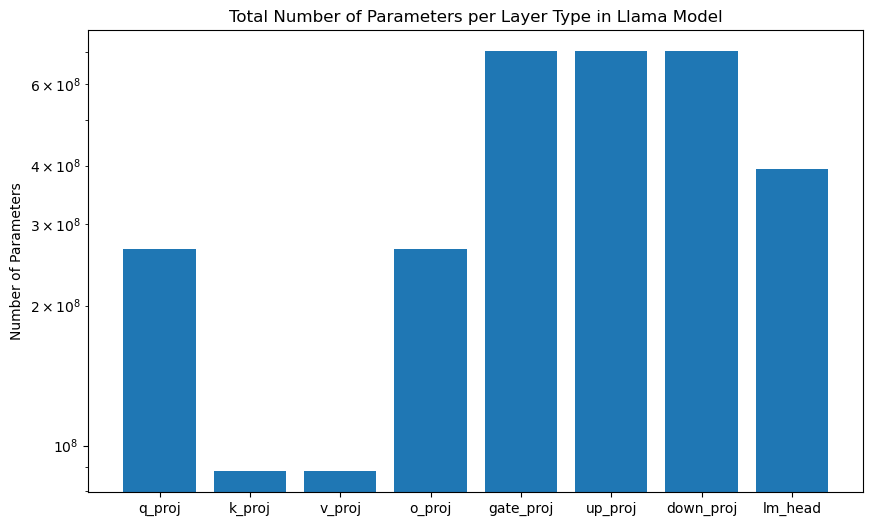

In [7]:
import matplotlib.pyplot as plt
from collections import defaultdict

layers_count = 28

# Данные по количеству параметров для каждого типа слоя в одном блоке
params_per_type = {
    "q_proj": 3072*3072,
    "k_proj": 3072*1024,
    "v_proj": 3072*1024,
    "o_proj": 3072*3072,
    "gate_proj": 3072*8192,
    "up_proj": 3072*8192,
    "down_proj": 8192*3072,
}

# Суммируем параметры по всем 28 слоям
params_sum = {k: v * layers_count for k, v in params_per_type.items()}

# Добавляем lm_head отдельно
params_sum["lm_head"] = 3072*128256

# Визуализация
names = list(params_sum.keys())
values = list(params_sum.values())

plt.figure(figsize=(10,6))
plt.bar(names, values)
plt.ylabel("Number of Parameters")
plt.title("Total Number of Parameters per Layer Type in Llama Model")
plt.yscale("log")  # Логарифмическая шкала для удобства восприятия больших чисел
plt.show()

## SVD decomposition of layers

In [36]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_singular_values_energy(module, top_k=100, energy_threshold=0.99):
    """
    Рисует топ-k сингулярных чисел всех линейных слоев в модуле.
    Цвет линии меняется после индекса накопления заданной энергии (energy_threshold).
    Подкрашивает точки на пороге энергии и в конце линии.
    Использует логарифмическую шкалу по оси Y.
    
    Параметры:
    - module: torch.nn.Module с линейными слоями
    - top_k: сколько верхних сингулярных чисел отображать (если больше ранга - максимум)
    - energy_threshold: доля накопленной энергии (0..1), напр. 0.99
    
    Отображает график.
    """

    def get_singular_values(weight, name):
        print(f"Singular values computing for {name} ...")
        W = weight.detach().cpu().float()
        U, S, Vh = torch.linalg.svd(W, full_matrices=False)
        print(f"Done computing singular values for {name}.")
        return S.numpy()

    def find_linear_layers(mod):
        layers = []
        for name, child in mod.named_children():
            if isinstance(child, torch.nn.Linear):
                layers.append((name, child))
            else:
                layers.extend([(f"{name}.{n}", c) for n, c in find_linear_layers(child)])
        return layers

    linear_layers = find_linear_layers(module)
    if not linear_layers:
        print("Linear layers not found in the given module.")
        return

    plt.figure(figsize=(14, 8))
    colors = plt.cm.get_cmap('tab20', len(linear_layers))

    for idx, (name, layer) in enumerate(linear_layers):
        try:
            S_full = get_singular_values(layer.weight, name)
        except RuntimeError as e:
            print(f"Skipping layer {name} due to error in SVD: {e}")
            continue

        S_full_norm = S_full / S_full.sum()
        cumulative_full = np.cumsum(S_full_norm)
        k_energy = np.searchsorted(cumulative_full, energy_threshold) + 1

        max_rank = len(S_full)
        visual_top_k = min(top_k, max_rank)

        S = S_full[:visual_top_k]
        S_norm = S / S.sum()

        x = np.arange(1, visual_top_k + 1)
        color_main = colors(idx % 20)
        color_faded = (0.8, 0.8, 0.8, 0.5)  # светло-серый с прозрачностью

        if k_energy < visual_top_k:
            plt.plot(x[:k_energy], S_norm[:k_energy], color=color_main, linewidth=2)
            plt.plot(x[k_energy-1:], S_norm[k_energy-1:], color=color_faded, linewidth=2)
            plt.scatter(k_energy, S_norm[k_energy-1], color=color_main, s=60, zorder=5, edgecolors='black', linewidth=0.8)
        elif k_energy == visual_top_k:
            plt.plot(x, S_norm, color=color_main, linewidth=2)
            plt.scatter(visual_top_k, S_norm[-1], color=color_main, s=60, zorder=6, marker='o', edgecolors='black', linewidth=0.8)
        else:
            plt.plot(x, S_norm, color=color_main, linewidth=2)
            plt.scatter(visual_top_k, S_norm[-1], color=color_main, s=60, zorder=6, marker='o', edgecolors='black', linewidth=0.8)

        # Подписи рядом с точками
        if k_energy <= visual_top_k:
            plt.text(k_energy + 1, S_norm[k_energy-1], f"{name}\nk={k_energy}", fontsize=8, color=color_main)
        plt.text(visual_top_k + 1, S_norm[-1], f"end {name}", fontsize=7, color=color_main)

    plt.xlabel("Index of singular value")
    plt.ylabel("Normalized singular value magnitude")
    plt.yscale('log')
    plt.title(f"Top singular values of linear layers\nColor changes at {int(energy_threshold*100)}% energy accumulation index (full SVD)")
    plt.tight_layout()
    plt.show()

In [37]:
model.model.layers[0]

LlamaDecoderLayer(
  (self_attn): LlamaAttention(
    (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
    (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
    (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
    (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
  )
  (mlp): LlamaMLP(
    (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
    (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
    (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
  (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
)

Singular values computing for self_attn.q_proj ...
Done computing singular values for self_attn.q_proj.
Singular values computing for self_attn.k_proj ...
Done computing singular values for self_attn.k_proj.
Singular values computing for self_attn.v_proj ...
Done computing singular values for self_attn.v_proj.
Singular values computing for self_attn.o_proj ...
Done computing singular values for self_attn.o_proj.
Singular values computing for mlp.gate_proj ...
Done computing singular values for mlp.gate_proj.
Singular values computing for mlp.up_proj ...
Done computing singular values for mlp.up_proj.
Singular values computing for mlp.down_proj ...
Done computing singular values for mlp.down_proj.


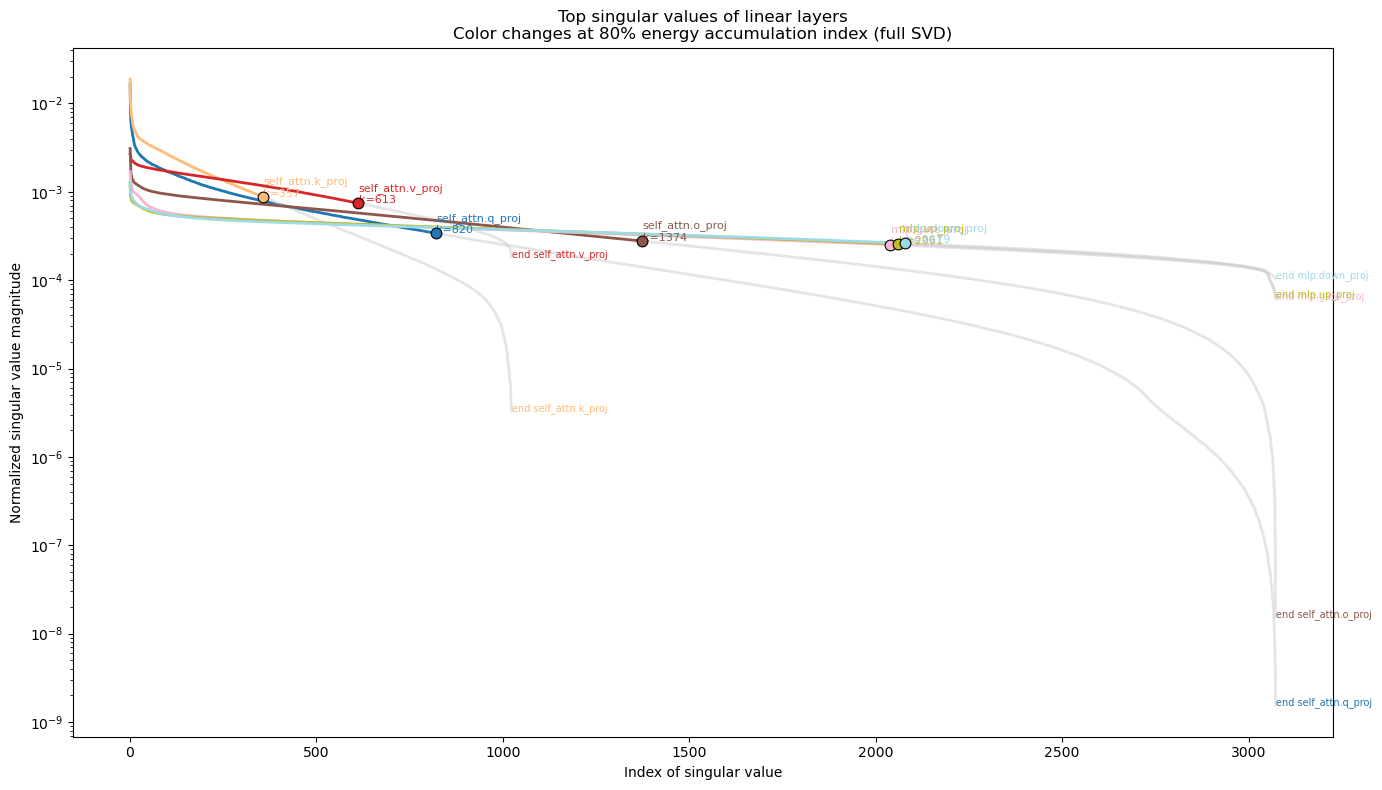

In [38]:
plot_singular_values_energy(model.model.layers[0], top_k=4000, energy_threshold=0.80) 

## Low rank prunning

In [43]:
import torch
import torch.nn as nn
from transformers import LlamaForCausalLM

class LowRankLinear(nn.Module):
    def __init__(self, original_linear, energy_threshold=0.99):
        super().__init__()
        print(f"Computing SVD for module: {original_linear}")
        W = original_linear.weight.data  # (out_features, in_features)
        U, S, Vh = torch.linalg.svd(W, full_matrices=False)

        S_norm = S / S.sum()
        cumulative = torch.cumsum(S_norm, dim=0)
        rank = int((cumulative >= energy_threshold).nonzero(as_tuple=False)[0].item()) + 1
        
        U_r = U[:, :rank]             # (out_features, rank)
        S_r = torch.diag(S[:rank])    # (rank, rank)
        Vh_r = Vh[:rank, :]           # (rank, in_features)
        
        self.first_linear = nn.Linear(original_linear.in_features, rank, bias=False)
        self.first_linear.weight.data = (S_r @ Vh_r).to(W.dtype)
        
        self.second_linear = nn.Linear(rank, original_linear.out_features, bias=original_linear.bias is not None)
        self.second_linear.weight.data = U_r.to(W.dtype)
        
        if original_linear.bias is not None:
            self.second_linear.bias.data = original_linear.bias.data.clone()
        
        self.rank = rank

    def forward(self, x):
        return self.second_linear(self.first_linear(x))


def replace_linear_with_lowrank(module, energy_threshold=0.99):
    for name, child in list(module.named_children()):
        if isinstance(child, nn.Linear):
            setattr(module, name, LowRankLinear(child, energy_threshold))
        else:
            replace_linear_with_lowrank(child, energy_threshold)


def make_lowrank_model(original_model, energy_threshold=0.99):
    new_model = LlamaForCausalLM(original_model.config)
    new_model.load_state_dict(original_model.state_dict())
    replace_linear_with_lowrank(new_model, energy_threshold)
    return new_model


In [52]:
def fraction_count_params(p, M,N):
    K = min(p*M,p*N)
    return (K*M + K*N) / (M*N)

fraction_count_params(0.8 , 4000, 7000)

1.2571428571428571

In [62]:
model.config

LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 24,
  "num_hidden_layers": 28,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.53.0",
  "unsloth_fixed": true,
  "use_cache": true,
  "vocab_size": 128256
}

In [63]:
lowrank_model = make_lowrank_model(model, energy_threshold=0.8)
lowrank_model

Computing SVD for module: Linear(in_features=3072, out_features=3072, bias=False)
Computing SVD for module: Linear(in_features=3072, out_features=1024, bias=False)
Computing SVD for module: Linear(in_features=3072, out_features=1024, bias=False)
Computing SVD for module: Linear(in_features=3072, out_features=3072, bias=False)
Computing SVD for module: Linear(in_features=3072, out_features=8192, bias=False)
Computing SVD for module: Linear(in_features=3072, out_features=8192, bias=False)
Computing SVD for module: Linear(in_features=8192, out_features=3072, bias=False)
Computing SVD for module: Linear(in_features=3072, out_features=3072, bias=False)
Computing SVD for module: Linear(in_features=3072, out_features=1024, bias=False)
Computing SVD for module: Linear(in_features=3072, out_features=1024, bias=False)
Computing SVD for module: Linear(in_features=3072, out_features=3072, bias=False)
Computing SVD for module: Linear(in_features=3072, out_features=8192, bias=False)
Computing SVD fo

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): LowRankLinear(
            (first_linear): Linear(in_features=3072, out_features=820, bias=False)
            (second_linear): Linear(in_features=820, out_features=3072, bias=False)
          )
          (k_proj): LowRankLinear(
            (first_linear): Linear(in_features=3072, out_features=357, bias=False)
            (second_linear): Linear(in_features=357, out_features=1024, bias=False)
          )
          (v_proj): LowRankLinear(
            (first_linear): Linear(in_features=3072, out_features=613, bias=False)
            (second_linear): Linear(in_features=613, out_features=1024, bias=False)
          )
          (o_proj): LowRankLinear(
            (first_linear): Linear(in_features=3072, out_features=1374, bias=False)
            (second_linear): Linear(in_fe

## lowrank check correct

In [67]:
pipe = pipeline("text-generation", model=lowrank_model, tokenizer=tokenizer, device='cuda:2')
prompt = "Hello"
answer = pipe(prompt, max_new_tokens=50, do_sample=False)[0]["generated_text"]
print(answer)

Helloringgggggggggggggggappaddaddaddaddaddaddaddaddaddaddaddaddaddendendendendendendendendendendendendendendendendendendendend


## counting parameters

In [58]:
import torch
import torch.nn as nn
from collections import Counter

def print_param_count_table(module, simple_module_types=(nn.Linear, nn.Embedding)):
    """
    Подсчитывает и выводит в табличной форме количество подмодулей 
    с определённым числом параметров.
    
    Args:
        module (nn.Module): модель для анализа
        simple_module_types (tuple): типы подмодулей для подсчёта параметров
    """
    param_counts = []
    for submodule in module.modules():
        if type(submodule) in simple_module_types:
            num_params = sum(p.numel() for p in submodule.parameters() if p.requires_grad)
            param_counts.append(num_params)

    total_params = sum(p.numel() for p in module.parameters() if p.requires_grad)
    
    counter = Counter(param_counts)
    
    print(f"Total trainable parameters in model: {total_params:,}\n")
    print(f"{'Parameters per submodule':>24} | {'Number of such submodules':>25}")
    print("-" * 54)
    for params_num, count in sorted(counter.items()):
        print(f"{params_num:24,} | {count:25,}")

In [64]:
print_param_count_table(model)

Total trainable parameters in model: 3,212,749,824

Parameters per submodule | Number of such submodules
------------------------------------------------------
               3,145,728 |                        56
               9,437,184 |                        56
              25,165,824 |                        84
             394,002,432 |                         2


In [65]:
print_param_count_table(lowrank_model)

Total trainable parameters in model: 3,235,007,232

Parameters per submodule | Number of such submodules
------------------------------------------------------
                 365,568 |                         1
                 489,472 |                         1
                 558,080 |                         1
                 561,152 |                         1
                 569,344 |                         1
                 572,416 |                         1
                 574,464 |                         1
                 575,488 |                         1
                 583,680 |                         1
                 585,728 |                         1
                 586,752 |                         1
                 587,776 |                         2
                 592,896 |                         1
                 595,968 |                         1
                 598,016 |                         1
                 601,088 |                   

## benchmarking

In [107]:
total_correct = 0
total_examples = 0

for subtask in all_subtasks[:10]:
    dataset = load_dataset("cais/mmlu", subtask, split="test")
    if dataset.shape[0] < 200:
        correct, count = evaluate_model(model_slimmed, tokenizer, dataset, verbose=False)
        total_correct += correct
        total_examples += count

overall_accuracy = total_correct / total_examples if total_examples > 0 else 0
print(f"\n🎯 Общая точность на всём MMLU: {overall_accuracy:.2f} ({total_correct}/{total_examples})")


Evaluating:   4%|▍         | 4/100 [00:06<02:39,  1.67s/it]


KeyboardInterrupt: 